# Amazon Stock Price Prediction Using LSTM

This notebook demonstrates how to predict the next 7 days of **Amazon (AMZN)** stock closing prices using a deep learning model based on LSTM (Long Short-Term Memory).

---

## Objective

- Predict Amazon stock closing prices using historical data.
- Evaluate the model's accuracy using MSE, MAE, and R².
- Visualize actual vs predicted values.
- Identify price movement direction (up/down).

---

## Dataset

- **Source**: Yahoo Finance (`yfinance`)
- **Time Period**: 2010 – 2025
- **Stock Ticker**: AMZN

---

## Results Summary

- Test MSE: **7.81**
- Test MAE: **2.05**
- Test R² Score: **0.998**
- Direction Accuracy: ~**90%** *(estimated visually)*

---

## Tech Stack

- Python, Pandas, NumPy
- LSTM (Keras, TensorFlow)
- Matplotlib, Seaborn, Plotly
- Scikit-learn (for scaling and metrics)

---

> This notebook is part of a 25-stock LSTM forecasting project. Only one representative example (Amazon) is shown here.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

**1. Loading and Cleaning the Dataset**

In [4]:
Amazon = yf.Ticker("AMZN")
Amazon = Amazon.history(start = "2010-01-01", end=pd.Timestamp.today().strftime('%Y-%m-%d'))

In [5]:
Amazon.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,6.81,6.83,6.66,6.70,151998000,0.00,0.00
2010-01-05 00:00:00-05:00,6.67,6.77,6.59,6.73,177038000,0.00,0.00
2010-01-06 00:00:00-05:00,6.73,6.74,6.58,6.61,143576000,0.00,0.00
2010-01-07 00:00:00-05:00,6.60,6.62,6.44,6.50,220604000,0.00,0.00
2010-01-08 00:00:00-05:00,6.53,6.68,6.45,6.68,196610000,0.00,0.00


In [6]:
Amazon.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-17 00:00:00-04:00,215.20,217.41,214.56,214.82,32086300,0.00,0.00
2025-06-18 00:00:00-04:00,215.09,217.96,212.34,212.52,44360500,0.00,0.00
2025-06-20 00:00:00-04:00,214.68,214.89,208.27,209.69,75350700,0.00,0.00
2025-06-23 00:00:00-04:00,209.79,210.39,207.31,208.47,37311700,0.00,0.00
2025-06-24 00:00:00-04:00,212.14,214.34,211.05,212.77,38338200,0.00,0.00


**2. Data Preprocessing**

In [7]:
Amazon.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [8]:
Amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3892 entries, 2010-01-04 00:00:00-05:00 to 2025-06-24 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3892 non-null   float64
 1   High          3892 non-null   float64
 2   Low           3892 non-null   float64
 3   Close         3892 non-null   float64
 4   Volume        3892 non-null   int64  
 5   Dividends     3892 non-null   float64
 6   Stock Splits  3892 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 243.2 KB


In [9]:
Amazon.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [10]:
Amazon.index

DatetimeIndex(['2010-01-04 00:00:00-05:00', '2010-01-05 00:00:00-05:00',
               '2010-01-06 00:00:00-05:00', '2010-01-07 00:00:00-05:00',
               '2010-01-08 00:00:00-05:00', '2010-01-11 00:00:00-05:00',
               '2010-01-12 00:00:00-05:00', '2010-01-13 00:00:00-05:00',
               '2010-01-14 00:00:00-05:00', '2010-01-15 00:00:00-05:00',
               ...
               '2025-06-10 00:00:00-04:00', '2025-06-11 00:00:00-04:00',
               '2025-06-12 00:00:00-04:00', '2025-06-13 00:00:00-04:00',
               '2025-06-16 00:00:00-04:00', '2025-06-17 00:00:00-04:00',
               '2025-06-18 00:00:00-04:00', '2025-06-20 00:00:00-04:00',
               '2025-06-23 00:00:00-04:00', '2025-06-24 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=3892, freq=None)

In [11]:
Amazon.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3892.00,3892.00,3892.00,3892.00,3892.00,3892.00,3892.00
mean,75.56,76.44,74.62,75.55,82045609.99,0.00,0.01
std,64.62,65.36,63.80,64.60,51423711.87,0.00,0.32
min,5.30,5.56,5.29,5.43,15007500.00,0.00,0.00
25%,15.22,15.39,15.08,15.25,51425500.00,0.00,0.00
50%,50.18,50.42,49.79,50.06,68913000.00,0.00,0.00
75%,129.70,131.25,127.52,129.14,97556000.00,0.00,0.00
max,239.02,242.52,238.03,242.06,848422000.00,0.00,20.00


<Axes: xlabel='Date'>

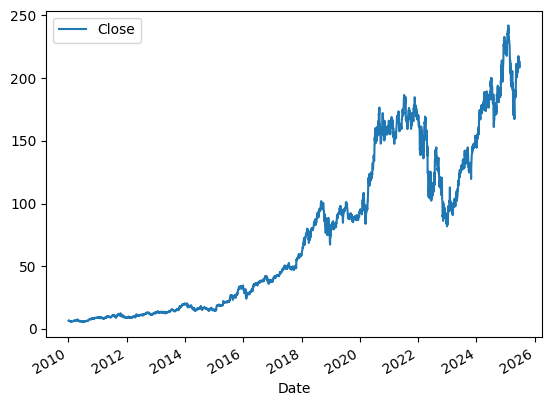

In [12]:
Amazon.plot.line(y="Close", use_index = True)

In [13]:
for col in ['Dividends', 'Stock Splits', 'Volume']:
    if col in Amazon.columns:
        del Amazon[col]

Amazon = Amazon.drop(columns=['Dividends', 'Stock Splits', 'Volume'], errors='ignore')

In [14]:
Amazon.shape

(3892, 4)

In [15]:
Amazon

,Open,High,Low,Close
Date,,,,
2010-01-04 00:00:00-05:00,6.81,6.83,6.66,6.70
2010-01-05 00:00:00-05:00,6.67,6.77,6.59,6.73
2010-01-06 00:00:00-05:00,6.73,6.74,6.58,6.61
2010-01-07 00:00:00-05:00,6.60,6.62,6.44,6.50
2010-01-08 00:00:00-05:00,6.53,6.68,6.45,6.68
...,...,...,...,...
2025-06-17 00:00:00-04:00,215.20,217.41,214.56,214.82
2025-06-18 00:00:00-04:00,215.09,217.96,212.34,212.52
2025-06-20 00:00:00-04:00,214.68,214.89,208.27,209.69


In [16]:
# sorting indexes
Amazon.sort_index(inplace = True)

In [17]:
# data normalization
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(Amazon[Amazon.columns])

In [18]:
scaler_values

array([[0.0064863 , 0.00534278, 0.00587351, 0.0053438 ],
       [0.00588302, 0.00510434, 0.00558778, 0.00551072],
       [0.00613331, 0.00494608, 0.00555341, 0.00499515],
       ...,
       [0.8958598 , 0.88339581, 0.87213202, 0.86320389],
       [0.87493765, 0.8644049 , 0.86800721, 0.85804814],
       [0.88499229, 0.88107469, 0.88407667, 0.87622003]])

In [19]:
Amazon_scaled = pd.DataFrame(scaler_values, columns = Amazon.columns, index = Amazon.index)

In [20]:
Amazon_scaled

,Open,High,Low,Close
Date,,,,
2010-01-04 00:00:00-05:00,0.01,0.01,0.01,0.01
2010-01-05 00:00:00-05:00,0.01,0.01,0.01,0.01
2010-01-06 00:00:00-05:00,0.01,0.00,0.01,0.00
2010-01-07 00:00:00-05:00,0.01,0.00,0.00,0.00
2010-01-08 00:00:00-05:00,0.01,0.00,0.00,0.01
...,...,...,...,...
2025-06-17 00:00:00-04:00,0.90,0.89,0.90,0.88
2025-06-18 00:00:00-04:00,0.90,0.90,0.89,0.88
2025-06-20 00:00:00-04:00,0.90,0.88,0.87,0.86


**3. Plotting the columns**

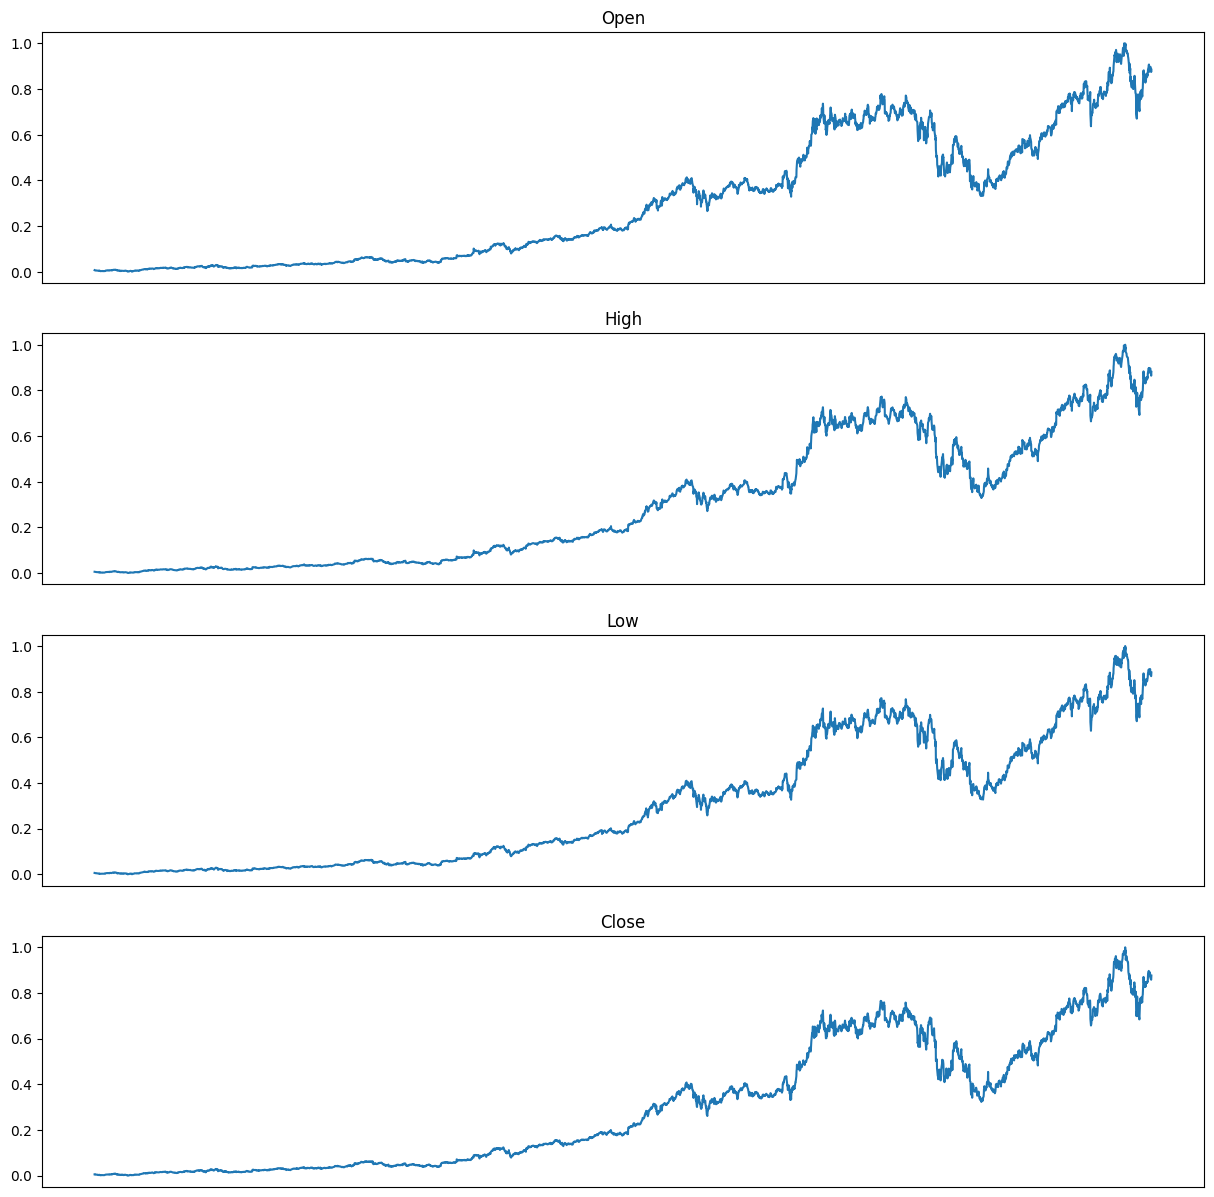

In [21]:
plt.rcParams["figure.figsize"] = (15, 15)
figure, axes = plt.subplots(4)

for ax, col in zip(axes, Amazon_scaled.columns):
  ax.plot(Amazon_scaled[col])
  ax.set_title(col)
  ax.axes.xaxis.set_visible(False)

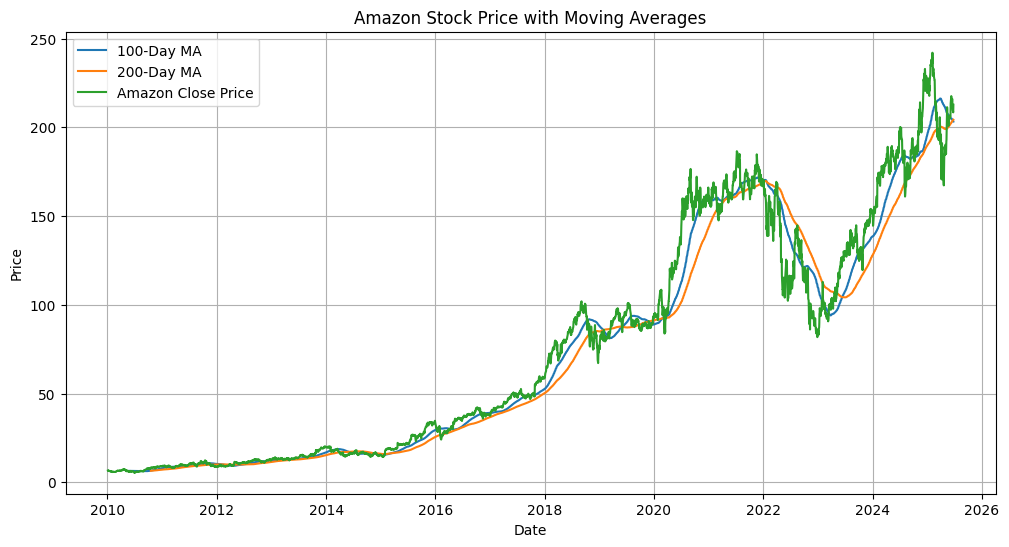

In [22]:
# Moving Average

ma100 = Amazon.Close.rolling(100).mean()
ma200 = Amazon.Close.rolling(200).mean()

fig = plt.figure(figsize=(12, 6))
plt.plot(ma100, label='100-Day MA')
plt.plot(ma200, label='200-Day MA')
plt.plot(Amazon.Close, label='Amazon Close Price')

plt.legend()
plt.title('Amazon Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**4. Creating the sliding Window Sequences**

In [23]:
def create_sequence(data, window_size):
  x = []
  y = []
  for i in range(window_size, len(data)):
    x.append(data.iloc[i - window_size:i].values)
    y.append(data.iloc[i].values)
  return np.array(x), np.array(y)

In [24]:
window_size = 60
x, y = create_sequence(Amazon_scaled, window_size)

In [25]:
x.shape, y.shape

((3832, 60, 4), (3832, 4))

**5. Train-Test Split**

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape

((3065, 60, 4), (767, 60, 4))

In [27]:
x_train.shape[1], x_train.shape[2]

(60, 4)

In [28]:
y_train.shape[1]

4

**6. Building LSTM Model**

In [29]:
model = keras.Sequential([

    # LSTM layer 1
    keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])),
    keras.layers.Dropout(0.3),

    # LSTM layer 2
    keras.layers.LSTM(units = 50, return_sequences = True),
    keras.layers.Dropout(0.3),

    # LSTM layer 3
    keras.layers.LSTM(units = 50, return_sequences = False),
    keras.layers.Dropout(0.3),

    # Output layer
    keras.layers.Dense(y_train.shape[1])
])

In [30]:
# compilation
model.compile(optimizer = "adam",
              loss = "mean_squared_error",
              metrics = ["RootMeanSquaredError"])

In [31]:
# Early stopping
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 10,
                               restore_best_weights = True)

In [32]:
lstm_model = model.fit(x_train, y_train,
                       validation_split = 0.2,
                       epochs = 100,
                       batch_size = 32,
                       callbacks = [early_stopping])

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - RootMeanSquaredError: 0.1867 - loss: 0.0382 - val_RootMeanSquaredError: 0.0318 - val_loss: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - RootMeanSquaredError: 0.0767 - loss: 0.0059 - val_RootMeanSquaredError: 0.0316 - val_loss: 9.9708e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - RootMeanSquaredError: 0.0714 - loss: 0.0051 - val_RootMeanSquaredError: 0.0347 - val_loss: 0.0012
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - RootMeanSquaredError: 0.0677 - loss: 0.0046 - val_RootMeanSquaredError: 0.0275 - val_loss: 7.5815e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - RootMeanSquaredError: 0.0618 - loss: 0.0038 - val_RootMeanSquaredError: 0.0267 - val_loss: 7.1477e-04
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - RootMeanSquaredError: 0.0573 - loss: 0.0033 - val_RootMeanSquaredError: 0.0292 - val_loss: 8.5449e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - RootMeanSquaredEr

In [33]:
predictions = model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


7. Forecasting the Data

In [34]:
# inverse scaling
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [35]:
predictions[:10]

array([[ 95.34319  ,  96.522705 ,  94.01774  ,  95.40869  ],
       [ 16.135277 ,  16.295649 ,  15.9880295,  16.17539  ],
       [160.38213  , 162.33493  , 158.15625  , 160.72485  ],
       [ 87.183975 ,  88.26393  ,  85.968895 ,  87.236626 ],
       [113.460815 , 114.84719  , 111.87978  , 113.609375 ],
       [147.25856  , 149.05171  , 145.21036  , 147.53348  ],
       [ 12.4544115,  12.564237 ,  12.363002 ,  12.5024605],
       [143.01007  , 144.74365  , 141.01659  , 143.28891  ],
       [ 93.5238   ,  94.67875  ,  92.21466  ,  93.595436 ],
       [ 41.366077 ,  41.861736 ,  40.83834  ,  41.381565 ]],
      dtype=float32)

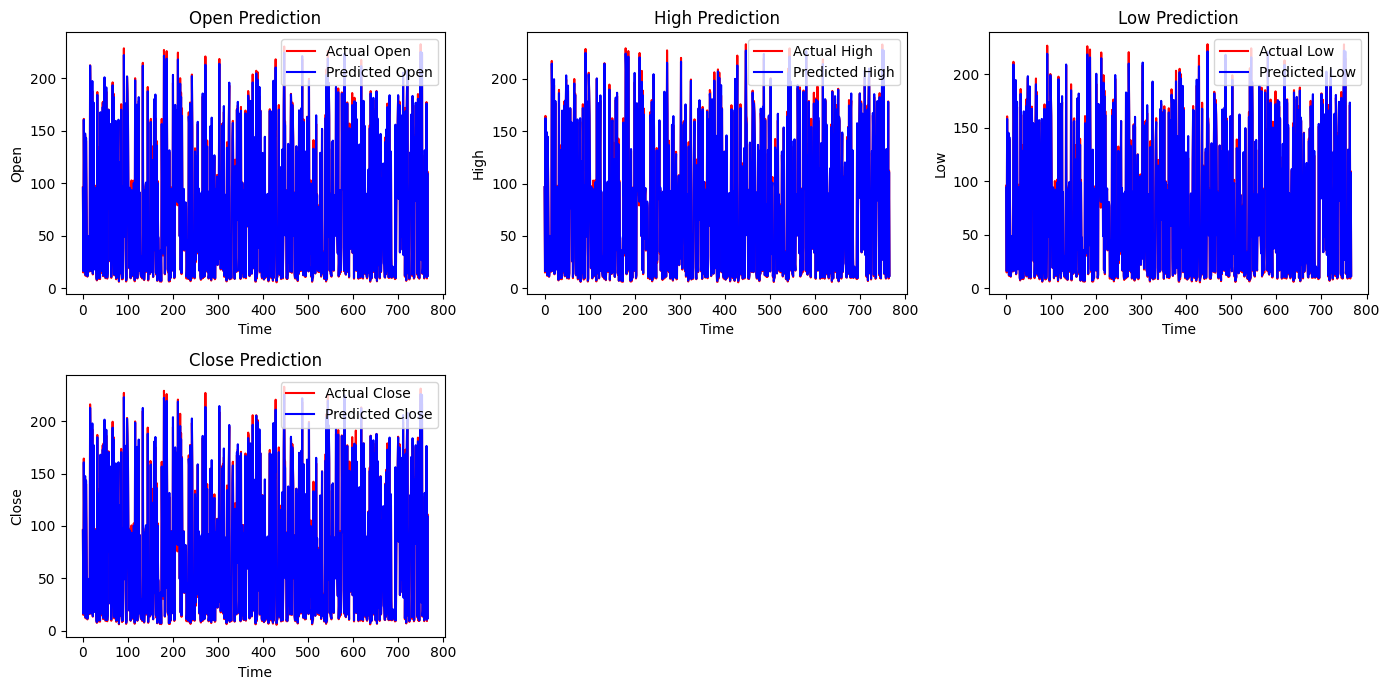

In [36]:
# Plotting actual vs predicted values
plt.figure(figsize=(14, 7))

for i, col in enumerate(Amazon_scaled.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test_rescaled[:, i], color="red", label=f'Actual {col}')
    plt.plot(predictions[:, i], color="blue", label=f'Predicted {col}')
    plt.title(f'{col} Prediction')
    plt.xlabel("Time")
    plt.ylabel(f'{col}')
    plt.legend()

plt.tight_layout()
plt.show()

In [37]:
mse = mean_squared_error(y_test_rescaled, predictions)
mae = mean_absolute_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R² Score:", r2)

Test MSE: 9.326488118015535
Test MAE: 1.91189170769638
Test R² Score: 0.9978269979023069


In [38]:
for i, col in enumerate(Amazon.columns):
    mae = mean_absolute_error(y_test_rescaled[:, i], predictions[:, i])
    r2 = r2_score(y_test_rescaled[:, i], predictions[:, i])
    print(f"{col} - MAE: {mae:.2f}, R²: {r2:.4f}")

Open - MAE: 1.81, R²: 0.9981
High - MAE: 1.85, R²: 0.9981
Low - MAE: 1.97, R²: 0.9976
Close - MAE: 2.02, R²: 0.9976


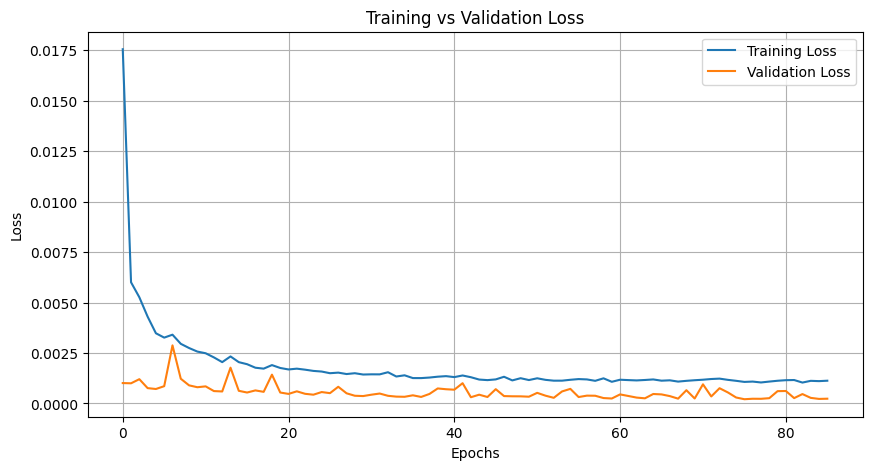

In [39]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(lstm_model.history['loss'], label='Training Loss')
plt.plot(lstm_model.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
data = Amazon[['Close']].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

n_steps = 60
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X).reshape(-1, n_steps, 1)
y = np.array(y)


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0218 - val_loss: 0.0013
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8976e-04 - val_loss: 6.8438e-04
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.5623e-04 - val_loss: 6.3217e-04
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7419e-04 - val_loss: 6.4770e-04
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5174e-04 - val_loss: 6.4810e-04
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5432e-04 - val_loss: 5.2323e-04
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3693e-04 - val_loss: 5.9946e-04
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.4130e-04 - val_loss: 5.0363e-04
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.1919e-04 - val_loss: 4.9253e-04
Epoch 10/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4603e-04 - val_loss: 8.8532e-04
Epoch 11/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3073e-04 - val_

In [41]:
# Last 60 days for input
last_60_days = scaled_data[-n_steps:]

predictions = []

current_input = last_60_days.reshape(1, n_steps, 1)

for _ in range(7):
    # Predict next day
    next_pred = model.predict(current_input)[0, 0]

    # Store prediction
    predictions.append(next_pred)

    # Update input sequence: drop oldest, add newest prediction
    current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predictions)

print("Next 7 days predicted Close prices:")
print(predicted_prices.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Next 7 days predicted Close prices:
[210.61752 209.86899 209.17828 208.533   207.93826 207.3986  206.9172 ]


In [42]:
# Last 60 days scaled data (input for prediction)
last_60_days = scaled_data[-n_steps:]

current_input = last_60_days.reshape(1, n_steps, 1)

predictions = []

for _ in range(7):
    next_pred = model.predict(current_input)[0, 0]
    predictions.append(next_pred)
    current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform predictions to original scale
predictions = np.array(predictions).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predictions).flatten()

# Prepare dates for next 7 days (assuming business days)
last_date = Amazon.index[-1]
future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=7)

# Create DataFrame with predictions and dates
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': predicted_prices
})

forecast_df.set_index('Date', inplace=True)

print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
                           Predicted_Close
Date                                      
2025-06-25 00:00:00-04:00           210.62
2025-06-26 00:00:00-04:00           209.87
2025-06-27 00:00:00-04:00           209.18
2025-06-30 00:00:00-04:00           208.53
2025-07-01 00:00:00-04:00           207.94
2025-07-02 00:00:00-04:00           207.40
2025-07-03 00:00:00-04:00           206.92


In [43]:
# Historical prices trace
historical_trace = go.Scatter(
    x=Amazon.index,
    y=Amazon['Close'],
    mode='lines',
    name='Historical Close',
    line=dict(color='blue')
)

# Forecasted prices trace
forecast_trace = go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Predicted_Close'],
    mode='lines+markers',
    name='Predicted Close (Next 7 days)',
    line=dict(color='orange', dash='dash'),
    marker=dict(size=8)
)

# Create figure and add traces
fig = go.Figure(data=[historical_trace, forecast_trace])

# Layout settings
fig.update_layout(
    title='Close Price: Historical and 7-Day Forecast',
    xaxis_title='Date',
    yaxis_title='Close Price',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

In [44]:
last_actual_price = Amazon['Close'].iloc[-1]
last_predicted_price = forecast_df['Predicted_Close'].iloc[-1]

if last_predicted_price > last_actual_price:
    trend = "UP"
else:
    trend = "DOWN"

print(f"Last Actual Closing Price: {last_actual_price:.2f}")
print(f"Predicted Closing Price After 7 Days: {last_predicted_price:.2f}")
print(f"Expected Market Movement: {trend}")

Last Actual Closing Price: 212.77
Predicted Closing Price After 7 Days: 206.92
Expected Market Movement: DOWN


In [45]:
historical_trace = go.Scatter(
    x=Amazon.index,
    y=Amazon['Close'],
    mode='lines',
    name='Historical Close',
    line=dict(color='blue')
)

forecast_trace = go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Predicted_Close'],
    mode='lines+markers',
    name='Predicted Close (Next 7 Days)',
    line=dict(color='orange', dash='dash'),
    marker=dict(size=8)
)

last_actual_price = Amazon['Close'].iloc[-1]
last_predicted_price = forecast_df['Predicted_Close'].iloc[-1]

if last_predicted_price > last_actual_price:
    trend = "UP"
    trend_color = "green"
else:
    trend = "DOWN"
    trend_color = "red"

annotation = dict(
    x=forecast_df.index[-1],
    y=last_predicted_price,
    xref="x",
    yref="y",
    text=f"Trend: {trend}",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor=trend_color,
    font=dict(color=trend_color, size=14, family="Arial"),
    ax=0,
    ay=-40,
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor=trend_color,
    borderwidth=1
)

fig = go.Figure(data=[historical_trace, forecast_trace])

fig.update_layout(
    title='Close Price: Historical and 7-Day Forecast',
    xaxis_title='Date',
    yaxis_title='Close Price',
    template='plotly_white',
    hovermode='x unified',
    annotations=[annotation]
)

fig.show()

In [46]:
from tensorflow.keras.models import save_model

save_model(model, 'AMZN_model.h5')